# Inspecting pickled `bigram` hits

## Imports

In [4]:
import pandas as pd
from pathlib import Path

## Define helper functions

### Copied from `./source/analyze/utils/`
jupyter won't import them 🤷‍♀️

In [5]:
def find_files(data_dir: Path, fname_glob: str, verbose: bool = False):
    path_iter = data_dir.rglob(fname_glob)
    if verbose:
        path_iter = tuple(path_iter)
        print_iter(
            [f'../{p.relative_to(data_dir)}' for p in path_iter], bullet='-',
            header=f'### {len(path_iter)} paths matching {fname_glob} found in {data_dir}')
    return path_iter


def print_iter(iter_obj,
               bullet: str = '▸',
               # //    logger: logging.Logger = None,
               # //    level: int = 20,
               header: str = ''):

    bullet_str = f'\n{bullet} '

    iter_str = bullet_str.join(f'{i}' for i in iter_obj)

    msg_str = f'\n{header}{bullet_str}{iter_str}'
    msg_str = msg_str.replace('\n\n', '\n').strip(f'{bullet} ')

    print(msg_str)


def cols_by_str(df: pd.DataFrame, start_str=None, end_str=None) -> list:
    if end_str:
        cols = df.columns[df.columns.str.endswith(end_str)]
        if start_str:
            cols = cols[cols.str.startswith(start_str)]
    elif start_str:
        cols = df.columns[df.columns.str.startswith(start_str)]
    else:
        cols = df.columns

    return cols.to_list()


def make_cats(orig_df: pd.DataFrame, columns: list = None) -> pd.DataFrame:
    df = orig_df.copy()
    if columns is None:
        cat_suff = ("code", "name", "path", "stem")
        columns = df.columns.str.endswith(cat_suff)  # type: ignore
    df.loc[:, columns] = df.loc[:, columns].astype(
        'string').fillna('_').astype('category')

    return df


def balance_sample(full_df: pd.DataFrame,
                   column_name: str = 'category',
                   sample_per_value: int = 5,
                   verbose: bool = False) -> tuple:
    '''
    create sample with no more than n rows satisfying each unique value
    of the given column. A value of -1 for `sample_per_value` will limit
    all values' results to the minimum count per value.
    '''
    info_message = ''
    subsamples = []
    for __, col_val_df in full_df.groupby(column_name):
        # take sample if 1+ and less than length of full dataframe
        if len(col_val_df) > sample_per_value > 0:
            subsample_df = col_val_df.sample(sample_per_value)
            subsamples.append(subsample_df)
        else:
            subsamples.append(col_val_df)

    # > trim all "by column" sub dfs to length of shortest if -1 given
    if sample_per_value == -1:
        trim_len = int(min(len(sdf) for sdf in subsamples))
        subsamples = [sdf.sample(trim_len)
                      for sdf in subsamples]

    b_sample = pd.concat(subsamples)

    if verbose:
        subset_info_table = (
            b_sample
            .value_counts(subset=column_name)
            .to_frame(name='count')
            .assign(percentage=b_sample
                    .value_counts(column_name, normalize=True)
                    .round(2) * 100)
            .to_markdown())
        label = (full_df.hits_df_pkl[0].stem + ' '
                 if 'hits_df_pkl' in full_df.columns
                 else '')
        info_message = (f'\n## {column_name} representation in {label}sample\n'
                        + subset_info_table)

    return b_sample, info_message


def concat_pkls(data_dir: Path = Path('/share/compling/data/sanpi/2_hit_tables'),
                fname_glob: str = '*.pkl.gz',
                pickles=None,
                convert_dtypes=False,
                verbose: bool = True) -> pd.DataFrame:
    if not pickles:
        pickles = find_files(Path(data_dir), fname_glob, verbose)

    # tested and found that it is faster to assign `corpus` intermittently
    sep_dfs = []
    for p in pickles:
        df = (pd.read_pickle(p).assign(corpus=p.stem.rsplit('_', 2)[0]))
        df = df.loc[:, cols_by_str(df, end_str=('lemma', 'id', 'text', 'window',
                      'category', 'Pol', 'sent')) + cols_by_str(df, start_str=('corpus', 'lemma'))]
        df = df.convert_dtypes()

        dup_check_cols = cols_by_str(df, end_str=('text', 'id', 'sent'))
        df = (df.loc[~df.duplicated(subset=dup_check_cols), :])
    
    c_df = pd.concat(sep_dfs)    
    dup_check_cols = cols_by_str(c_df, end_str=('text', 'id', 'sent'))
    c_df = (c_df.loc[~c_df.duplicated(subset=dup_check_cols), :])
    c_df = make_cats(c_df, (['corpus'] + cols_by_str(c_df, start_str=('nr', 'neg', 'adv'),
                                                 end_str=('lemma', 'form'))))

    return c_df

### copied from `./source/analyze_deps.py`:

In [6]:
def _optimize_df(df: pd.DataFrame) -> pd.DataFrame:

    # print('Original Dataframe:')
    # df.info(memory_usage='deep')

    # > drop unneeded string columns
    # was:
    #   for c in udf.cols_by_str(df, start_str=('context', 'text', 'sent_text', 'token')):
    for c in cols_by_str(df, start_str=('context', 'token', 'utt')):
        df.pop(c)

    # > select only non-`object` dtype columns
    relevant_cols = df.columns[~df.dtypes.astype(
        'string').str.endswith(('object'))]
    # limit df to `relevant_cols`
    df = df[relevant_cols]

    # > create empty dataframe with `relevant_cols` as index/rows
    df_info = pd.DataFrame(index=relevant_cols)

    df_info = df_info.assign(
        mem0=df.memory_usage(deep=True),
        dtype0=df.dtypes.astype('string'),
        defined_values=df.count(),
        unique_values=df.apply(pd.unique, axis=0).apply(len))
    df_info = df_info.assign(
        ratio_unique=(df_info.unique_values/df_info.defined_values).round(2))

    cat_candidates = df_info.loc[df_info.ratio_unique < 0.8,
                                 :].loc[df_info.dtype0 != 'category'].index.to_list()
    #was: catted_df = udf.make_cats(df.copy(), cat_candidates)
    catted_df = make_cats(df.copy(), cat_candidates)

    df_info = df_info.assign(dtype1=catted_df.dtypes,
                             mem1=catted_df.memory_usage(deep=True))
    df_info = df_info.assign(mem_change=df_info.mem1-df_info.mem0)
    print(df_info.sort_values(
        ['mem_change', 'ratio_unique', 'dtype0']).to_markdown())
    mem_improved = df_info.loc[df_info.mem_change < 0, :].index.to_list()
    for c in df.columns[~df.columns.isin(mem_improved)]:
        print(c, '\t', df.loc[:, c].dtype)
    df.loc[:, mem_improved] = catted_df.loc[:, mem_improved]
    print('Category Converted dataframe:')
    df.info(memory_usage='deep')

    return df

### Newly created

In [7]:
def show_counts(df, columns):
    return df.value_counts(columns).to_frame().rename(columns={0: 'count'})

def summarize_text_cols(tdf: pd.DataFrame):

    summary = tdf.describe().transpose()
    summary = summary.assign(top_percent=(
        ((pd.to_numeric(summary.freq) / len(tdf)))*100).round(2))
    summary = summary.rename(columns={'top': 'top_value', 'freq': 'top_freq'})

    return summary.convert_dtypes().sort_values('unique')

## Load Data

In [8]:
# ddf = concat_pkls(
#     data_dir=Path('/share/compling/data/sanpi/2_hit_tables'),
#     # fname_glob='bigram*hits.pkl.gz',
#     fname_glob='bigram-[AP]??[TV_]*hits.pkl.gz',
#     convert_dtypes=True)

def select_pickles():
    # HACK -- `with-context/` is temporary!
    pickle_dir = Path(
        '/share/compling/data/sanpi/2_hit_tables/')
    # > make dataframe to load smallest files first (for testing)
    pkl_df = pd.DataFrame(pickle_dir.rglob(
        'bigram-*hits.pkl.gz'), columns=['path'])
    pkl_df = pkl_df.assign(size=pkl_df.path.apply(lambda f: f.stat().st_size))
    pkl_df = pkl_df.sort_values('size')
    print(pkl_df.reset_index().astype('string').to_markdown())
    pkl_paths = pkl_df.path.to_list()
    return pkl_paths
hit_pkls = select_pickles()


|     |   index | path                                                                                            |      size |
|----:|--------:|:------------------------------------------------------------------------------------------------|----------:|
|   0 |      61 | /share/compling/data/sanpi/2_hit_tables/scoped/bigram-PccTe_with-relay_hits.pkl.gz              |     47450 |
|   1 |      43 | /share/compling/data/sanpi/2_hit_tables/scoped/bigram-PccVa_with-relay_hits.pkl.gz              |     47672 |
|   2 |      22 | /share/compling/data/sanpi/2_hit_tables/raised/bigram-PccVa_neg-raised_hits.pkl.gz              |     61657 |
|   3 |       0 | /share/compling/data/sanpi/2_hit_tables/raised/bigram-PccTe_neg-raised_hits.pkl.gz              |     61667 |
|   4 |      70 | /share/compling/data/sanpi/2_hit_tables/contig/bigram-PccTe_sans-relay_hits.pkl.gz              |    856805 |
|   5 |      71 | /share/compling/data/sanpi/2_hit_tables/contig/bigram-PccVa_sans-relay_hits.pkl.gz    

In [10]:
ddf = concat_pkls(pickles=hit_pkls[:75], convert_dtypes=True)
# ddf = concat_pkls(pickles=hit_pkls[:50], convert_dtypes=True)

ValueError: No objects to concatenate

### Optimize DataFrame

In [ ]:
odf = _optimize_df(ddf)

|             |     mem0 | dtype0   |   defined_values |   unique_values |   ratio_unique | dtype1   |     mem1 |   mem_change |
|:------------|---------:|:---------|-----------------:|----------------:|---------------:|:---------|---------:|-------------:|
| match_id    | 17574729 | string   |           263594 |            6283 |           0.02 | category |  1086069 |    -16488660 |
| category    | 16606422 | string   |           263594 |               3 |           0    | category |   263891 |    -16342531 |
| adj_lemma   | 16816300 | string   |           263594 |            7675 |           0.03 | category |  1295691 |    -15520609 |
| adj_form    | 16831481 | string   |           263594 |            8110 |           0.03 | category |  1323527 |    -15507954 |
| relay_lemma | 14558993 | string   |           179219 |           12100 |           0.07 | category |  1564856 |    -12994137 |
| colloc      | 18357547 | string   |           263594 |           49088 |           0.19 | categ

/tmp/ipykernel_2407718/2635148037.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, mem_improved] = catted_df.loc[:, mem_improved]


Category Converted dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 263594 entries, pcc_eng_test_3.00526_x35290_08:1-4-8-9 to pcc_eng_29_001.9962_x0015951_068:3-4-8-9
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   colloc       263594 non-null  category
 1   sent_text    263594 non-null  string  
 2   relay_form   263594 non-null  category
 3   neg_form     263594 non-null  category
 4   adv_form     263594 non-null  category
 5   adj_form     263594 non-null  category
 6   hit_text     263594 non-null  category
 7   text_window  263594 non-null  string  
 8   sent_id      263594 non-null  string  
 9   match_id     263594 non-null  category
 10  colloc_id    263594 non-null  string  
 11  lemma_str    263594 non-null  string  
 12  relay_lemma  263594 non-null  category
 13  neg_lemma    263594 non-null  category
 14  adv_lemma    263594 non-null  category
 15  adj_lemma    263594 non-null  category
 

In [ ]:
columns = odf.columns[~odf.columns.isin(cols_by_str(
    odf, start_str=('dep_m', 'dep_n', 'dep_r', 'context')))].to_list()
columns.sort()
odf = odf.loc[:, columns]
len(odf) == len(ddf)


True

⚠️ remove `any-direct` hits with `x_...` values filled

In [ ]:
if 'x_form' in odf.columns: 
    x_cols = cols_by_str(odf, start_str='x')
    print(x_cols)

    odf = odf.loc[odf.x_form == '_', ~odf.columns.isin(x_cols)]

In [ ]:
odf.loc[odf.corpus.str.contains('Pcc'), 'corpus_group'] = 'puddin'
odf.loc[odf.corpus.str.endswith(('Nyt1', 'Nyt2', 'Apw')), 'corpus_group'] = 'news'

general_counts = show_counts(odf, ['category', 'corpus_group'])

general_counts = general_counts.unstack()
general_counts = general_counts.sort_values(('count', 'puddin'), ascending=False)  # type: ignore
general_counts

count          
corpus_group     news    puddin
category                       
scoped        12405.0  166814.0
raised        11428.0   66748.0
contig            NaN    6199.0

*NOTE:* 👇 *`odf` is shorter (fewer rows) than original loaded hits because adverbs other than `'exactly'` have been dropped.*

In [ ]:
len(odf) < len(ddf)


False

### Add `conllu_id` and drop unused columns

In [ ]:
odf = odf.assign(conllu_id=odf.sent_id.str.rsplit('_', 2).str.get(0).str.split(
    '.').str.get(0).astype('string').astype('category'))  # type: ignore
tdf = odf[cols_by_str(odf, end_str=('lemma', 'id', 'text', 'window',
                      'category', 'Pol')) + cols_by_str(odf, start_str=('corpus', 'lemma'))]
print(f'Total hits for all patterns: {len(tdf)}')
summary_tdf = summarize_text_cols(tdf)
summary_tdf


Total hits for all patterns: 263594


,count,unique,top_value,top_freq,top_percent
corpus_group,263594,2,puddin,239761,90.96
category,263594,3,scoped,179219,67.99
neg_lemma,263594,15,no,95292,36.15
nr_lemma,263594,24,_,185418,70.34
corpus,263594,34,bigram-Pcc21,12361,4.69
adv_lemma,263594,2225,too,30360,11.52
match_id,263594,6283,1-2-4-5,17968,6.82
adj_lemma,263594,7675,good,11688,4.43
conllu_id,263594,9426,pcc_eng_val_2,1268,0.48
relay_lemma,263594,12099,_,84376,32.01


## Identify $PosPol$ and $NegPol$ contexts

### Option A
bare collocation tokens (`advadj.all-RB-JJs` pattern match) which do not appear as matches for any other pattern match (i.e. $NegPol$ contexts).

*That is, the `colloc_id` (unique `ADV` & `ADJ` nodes in unique sentence tokens) is not duplicated.*

```{python}
tdfp_a = tdf.loc[(tdf.category=='advadj') & (~tdf.duplicated(subset='colloc_id', keep=False)), :]
```

### Option B
categorize $NegPol$ set first (`tdfn`), then compute complement of that (i.e. $ALL - NegPol$)

```{python}
tdfn = tdf.loc[tdf.neg_lemma!='_', :]
tdfp = tdf.loc[~tdf.colloc_id.isin(tdfn.colloc_id), :]
```

### Options A and B are identical

`all(tdfp_a.index == tdfp_b.index)` evaluates as true

So, since $NegPol$ is more directly defined, and has to be separated out anyway, it's simpler to just get the "complement", (`tdfp_b` method)

In [ ]:
tdfn = tdf.loc[tdf.neg_lemma != '_', :]
summarize_text_cols(tdfn)


,count,unique,top_value,top_freq,top_percent
corpus_group,263594,2,puddin,239761,90.96
category,263594,3,scoped,179219,67.99
neg_lemma,263594,15,no,95292,36.15
nr_lemma,263594,24,_,185418,70.34
corpus,263594,34,bigram-Pcc21,12361,4.69
adv_lemma,263594,2225,too,30360,11.52
match_id,263594,6283,1-2-4-5,17968,6.82
adj_lemma,263594,7675,good,11688,4.43
conllu_id,263594,9426,pcc_eng_val_2,1268,0.48
relay_lemma,263594,12099,_,84376,32.01


In [ ]:
tdfn[['neg_lemma', 'adv_lemma', 'adj_lemma', 'hit_text', 
      'text_window', 
    #   'sent_text'
      ]].sample(25)

,neg_lemma,adv_lemma,adj_lemma,hit_text,text_window
hit_id,,,,,
pcc_eng_17_076.7114_x1223615_32:06-07-22-23,rarely,only,logical,rarely offers three decades of job security pl...,fickle employment market rarely offers three d...
pcc_eng_08_008.1914_x0116299_12:13-15-17-18,few,as,fraught,few demographic categories are as fraught,"the DPRK , few demographic categories are as f..."
pcc_eng_13_021.9275_x0338306_11:40-42-47-48,never,finally,able,"never did come out , we were finally able","while the sun never did come out , we were fin..."
pcc_eng_16_074.8470_x1195017_43:1-2-4-5,few,as,frustrating,Few things are as frustrating,Few things are as frustrating as having a
pcc_eng_19_038.7455_x0609019_16:21-22-24-25,few,more,familiar,few songs are more familiar,"Grace , "" few songs are more familiar , and yet"
pcc_eng_04_043.9559_x0694086_11:3-4-7-8,few,especially,broad,few films have been especially broad,His past few films have been especially broad ...
pcc_eng_13_095.0590_x1520108_47:08-09-12-13,not,as,progressive,n't think Labour is as progressive,", I do n't think Labour is as progressive or i..."
pcc_eng_17_093.1097_x1488440_075:01-03-18-19,without,not,possible,Without the interactions and development produ...,Without the interactions and development produ...
pcc_eng_17_085.4247_x1364425_88:12-13-16-17,no,very,wise,"no doubt , is very wise","floor project , no doubt , is very wise , very..."


In [ ]:
tdfp = tdf.loc[~tdf.colloc_id.isin(tdfn.colloc_id), :]
summarize_text_cols(tdfp)


,count,unique,top_value,top_freq,top_percent
adj_lemma,0,0,<NA>,<NA>,<NA>
adv_lemma,0,0,<NA>,<NA>,<NA>
category,0,0,<NA>,<NA>,<NA>
colloc_id,0,0,<NA>,<NA>,<NA>
hit_text,0,0,<NA>,<NA>,<NA>
match_id,0,0,<NA>,<NA>,<NA>
neg_lemma,0,0,<NA>,<NA>,<NA>
nr_lemma,0,0,<NA>,<NA>,<NA>
relay_lemma,0,0,<NA>,<NA>,<NA>
sent_id,0,0,<NA>,<NA>,<NA>


## Assign `polarity` and recombine

In [ ]:
tdfp = tdfp.assign(polarity='positive')
tdfn = tdfn.assign(polarity='negative')
tdf_with_overlap = tdf
pol_union_df = pd.concat([tdfp, tdfn]).sort_values('colloc_id')

print(
    f'Total bare `exactly ADJ` collocations: {odf.category.value_counts()["advadj"]}')
print(
    f'Total `exactly` pattern hits (+ NegPol pattern overlap): {len(pol_union_df)}')
print(f'PosPol: {round(100*len(tdfp)/len(pol_union_df))}% : {len(tdfp)} hits')
print(
    f'NegPol: {str(round(100*len(tdfn)/len(pol_union_df))).zfill(2)}% : {len(tdfn)} hits')


KeyError: 'advadj'

### Pickle Pos+Neg Dataframe

In [ ]:
# pol_union_df.to_pickle(
#     '/share/compling/projects/sanpi/notebooks/bigram_out/all-exactly-hits_text+polarity.pkl.gz')


## Frequency by Polarity

### Simple Frequency Comparison

In [ ]:
top_200 = show_counts(pol_union_df, ['polarity', 'adj_lemma']).head(200)
top_200


count
polarity adj_lemma         
positive much         83407
         important    61485
         many         57946
         cloudy       50578
         good         50526
...                     ...
         lucrative     2367
         unclear       2359
         fine          2356
         present       2353
         appropriate   2348

[200 rows x 1 columns]

In [ ]:
top_200_neg = show_counts(pol_union_df.loc[pol_union_df.polarity=='negative', :], ['polarity', 'adj_lemma']).head(200)
top_200_neg


count
polarity adj_lemma        
negative clear       16551
         available   15788
         good         3571
         bad          3114
         sure         2737
...                    ...
         special        69
         sweet          68
         promising      68
         rich           68
         satisfying     67

[200 rows x 1 columns]

In [ ]:
spread_top_200 = top_200.unstack(level='polarity', fill_value=0)
spread_top_200.sort_values(('count', 'negative'),
                           ascending=False).head(30)  # type: ignore


count         
polarity      negative positive
adj_lemma                      
clear            16551    12220
available        15788     8526
good              3571    50526
bad               3114    12827
sure              2737     3957
much                 0    83407
experienced          0     3132
independent          0     3378
right                0     3374
necessary            0     3363
advanced             0     3353
sophisticated        0     3252
wide                 0     3250
nervous              0     3249
profitable           0     3206
fast                 0     3132
old                  0     3477
angry                0     3116
dramatic             0     3109
volatile             0     3104
unpopular            0     3103
friendly             0     3088
similar              0     3082
prestigious          0     3082
disappointing        0     2991
careful              0     2959
painful              0     2957
tight                0     3414
impressive           0     3546
rare                 0     3505

In [ ]:
spread_top_200.sort_values(('count', 'positive'),
                           ascending=False).head(30)  # type: ignore


count         
polarity   negative positive
adj_lemma                   
much              0    83407
important         0    61485
many              0    57946
cloudy            0    50578
good           3571    50526
difficult         0    36910
high              0    29277
more              0    27604
likely            0    25740
popular           0    21585
serious           0    20405
higher            0    19894
strong            0    19579
happy             0    17873
different         0    17554
dangerous         0    16575
powerful          0    16452
low               0    16010
expensive         0    14544
lower             0    13968
concerned         0    13841
close             0    13384
bad            3114    12827
recent            0    12710
better            0    12651
hard              0    12621
clear         16551    12220
successful        0    11762
little            0    11601
small             0    10738

### Crosstabulate adjective by context polarity

In [ ]:
freq_dist = pd.crosstab(pol_union_df.adj_lemma,
                        pol_union_df.polarity,
                        margins=True, margins_name='TOTAL')

freq_dist = freq_dist.assign(
    ratio_neg=(freq_dist.negative/freq_dist.TOTAL).round(3),
    ratio_pos=(freq_dist.positive/freq_dist.TOTAL).round(3))

freq_dist = freq_dist.assign(
    bin_neg=freq_dist.ratio_neg.round(1),
    bin_pos=freq_dist.ratio_pos.round(1))

cols = freq_dist.columns.to_list()
cols.pop(cols.index('TOTAL'))
freq_dist = freq_dist[['TOTAL'] + cols]

freq_dist.sort_values('TOTAL', ascending=False)


polarity,TOTAL,negative,positive,ratio_neg,ratio_pos,bin_neg,bin_pos
adj_lemma,,,,,,,
TOTAL,2572234,113814,2458420,0.044,0.956,0.0,1.0
much,84741,1334,83407,0.016,0.984,0.0,1.0
important,62835,1350,61485,0.021,0.979,0.0,1.0
many,58233,287,57946,0.005,0.995,0.0,1.0
good,54097,3571,50526,0.066,0.934,0.1,0.9
...,...,...,...,...,...,...,...
black-supported,1,0,1,0.000,1.000,0.0,1.0
misspell,1,0,1,0.000,1.000,0.0,1.0
missionary-like,1,0,1,0.000,1.000,0.0,1.0


In [ ]:
freq_thresh5 = freq_dist.loc[freq_dist.TOTAL >= 5, :]
freq_thresh5 = freq_thresh5.sort_values(
    ['bin_neg', 'TOTAL', 'ratio_neg'], ascending=False)
freq_thresh5.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh5.csv')
freq_thresh5


polarity,TOTAL,negative,positive,ratio_neg,ratio_pos,bin_neg,bin_pos
adj_lemma,,,,,,,
0,29,26,3,0.897,0.103,0.9,0.1
batsmen,31,24,7,0.774,0.226,0.8,0.2
curfew,6,5,1,0.833,0.167,0.8,0.2
fussed,6,5,1,0.833,0.167,0.8,0.2
begun,5,4,1,0.800,0.200,0.8,0.2
...,...,...,...,...,...,...,...
y,5,0,5,0.000,1.000,0.0,1.0
yellow-carded,5,0,5,0.000,1.000,0.0,1.0
yemeni,5,0,5,0.000,1.000,0.0,1.0


<AxesSubplot:ylabel='Frequency'>

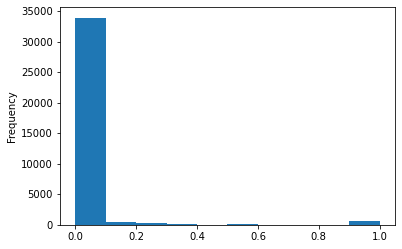

In [ ]:
freq_dist.ratio_neg.plot(kind='hist')

<AxesSubplot:xlabel='negative', ylabel='positive'>

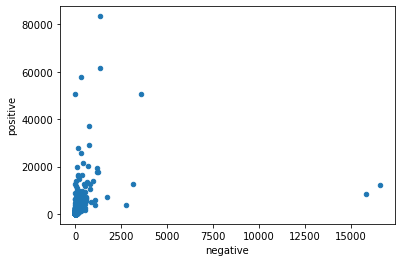

In [ ]:
freq_dist.loc[freq_dist.index!='TOTAL', ['negative', 'positive']].plot(x='negative', y ='positive', kind='scatter')

<AxesSubplot:ylabel='Density'>

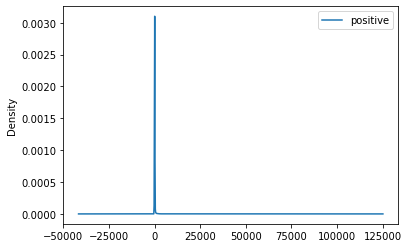

In [ ]:
freq_dist.loc[freq_dist.index!='TOTAL', ['negative', 'positive']].plot(x='negative', y ='positive', kind='density')

<AxesSubplot:ylabel='Frequency'>

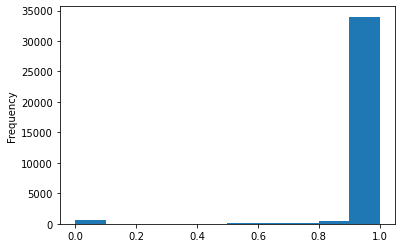

In [ ]:
freq_dist.ratio_pos.plot(kind='hist')

In [ ]:
freq_thresh100 = freq_dist.loc[freq_dist.TOTAL >= 100, :]
freq_thresh100 = freq_thresh100.sort_values(
    ['ratio_neg','TOTAL', 'bin_neg', ], ascending=False)
freq_thresh100.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh100.csv')
freq_thresh100


polarity,TOTAL,negative,positive,ratio_neg,ratio_pos,bin_neg,bin_pos
adj_lemma,,,,,,,
available,24314,15788,8526,0.649,0.351,0.6,0.4
clear,28771,16551,12220,0.575,0.425,0.6,0.4
sure,6694,2737,3957,0.409,0.591,0.4,0.6
ripe,200,66,134,0.330,0.670,0.3,0.7
comparable,279,85,194,0.305,0.695,0.3,0.7
...,...,...,...,...,...,...,...
pashtun,102,0,102,0.000,1.000,0.0,1.0
three-month,102,0,102,0.000,1.000,0.0,1.0
distrustful,100,0,100,0.000,1.000,0.0,1.0


In [ ]:
freq_thresh200 = freq_dist.loc[freq_dist.TOTAL >= 200, :]
freq_thresh200 = freq_thresh200.sort_values(
    ['bin_neg', 'TOTAL', 'ratio_neg'], ascending=False)
freq_thresh200.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh200.csv')
freq_thresh200


polarity,TOTAL,negative,positive,ratio_neg,ratio_pos,bin_neg,bin_pos
adj_lemma,,,,,,,
clear,28771,16551,12220,0.575,0.425,0.6,0.4
available,24314,15788,8526,0.649,0.351,0.6,0.4
sure,6694,2737,3957,0.409,0.591,0.4,0.6
binding,1979,505,1474,0.255,0.745,0.3,0.7
final,382,105,277,0.275,0.725,0.3,0.7
...,...,...,...,...,...,...,...
southwest,201,0,201,0.000,1.000,0.0,1.0
engaging,200,5,195,0.025,0.975,0.0,1.0
feminine,200,5,195,0.025,0.975,0.0,1.0


## Save $PosPol$ text data

Since $PosPol$ is defined as the complement of $NegPol$, accuracy relies on $NegPol$ catching all relevant cases.

To ensure pattern specifications are sufficiently inclusive, all sentences with supposedly positive polarity
should be manually inspected for any errant (uncaught) negative lemmas, as identified in the $NegPol$ pattern specifications.

```{ocaml}
NEG [lemma="hardly"|"scarcely"|"never"|"rarely"|"barely"|"seldom"|"no"|"nothing"|"none"|"nobody"|"neither"|"without"|"few"|"nor"];  
```

- [x] create simplified output of $PosPol$/`tdfp` sentence text data, with necessary identifiers
- [x] save as csv
- [ ] grep `pos_sentences.csv` for each neg lemma:\
  *There should not be any negative lemmas an `exactly JJ` collocation in its scope.*


In [ ]:
select_cols = ['adj_lemma', 'text_window', 'sent_text',
               'sent_id', 'conllu_id', 'corpus']
pos_text_info = tdfp.loc[:, select_cols]
pos_text_info = pos_text_info.assign(
    adj_neg_ratio=pos_text_info.adj_lemma.apply(lambda a: freq_dist.loc[a, 'ratio_neg'] if a in freq_dist.index else None))  # type: ignore
pos_text_info.sort_values(['adj_neg_ratio', 'conllu_id'], ascending=False)
pos_text_info.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/pos_sentences.csv')

# tdfp.adj_lemma[~tdfp.adj_lemma.isin(freq_dist.index)].value_counts()
# TODO?? why does it say there is a mismatch between the crosstab and pospol adj set?
# ^ 🤔 probably something to do with categorical dtype


In [ ]:
freq_thresh5.describe().round(2)

polarity,TOTAL,negative,positive,ratio_neg,ratio_pos,bin_neg,bin_pos
count,9083.00,9083.00,9083.00,9083.00,9083.00,9083.00,9083.00
mean,562.06,24.94,537.12,0.03,0.97,0.02,0.98
std,27057.49,1220.49,25860.63,0.06,0.06,0.06,0.06
min,5.00,0.00,1.00,0.00,0.10,0.00,0.10
25%,8.00,0.00,8.00,0.00,0.97,0.00,1.00
50%,19.00,0.00,18.00,0.00,1.00,0.00,1.00
75%,74.00,2.00,72.00,0.03,1.00,0.00,1.00
max,2572234.00,113814.00,2458420.00,0.90,1.00,0.90,1.00


In [ ]:
# pol_union_thresh5 = pol_union_df.loc[pol_union_df.adj_lemma]
adj_x_cat = (pd.crosstab(index=pol_union_df.adj_lemma, columns=pol_union_df.category, 
                         margins=True, margins_name='TOTAL', normalize='index')
             .rename(columns={'advadj':'PosPol', 'contig':'contig_NegPol', 
                              'raised': 'raised_NegPol', 'scoped':'scoped_NegPol'})
             .round(3))
adj_x_cat.loc[adj_x_cat.index.isin(freq_thresh200.index), :]

category,PosPol,contig_NegPol,raised_NegPol,scoped_NegPol
adj_lemma,,,,
5-4,1.000,0.000,0.000,0.000
able,0.905,0.087,0.002,0.006
absent,0.989,0.007,0.001,0.002
absurd,0.967,0.030,0.002,0.002
abundant,0.981,0.019,0.000,0.000
...,...,...,...,...
worthy,0.949,0.045,0.003,0.003
wrong,0.954,0.042,0.002,0.002
young,0.987,0.010,0.001,0.001


In [ ]:
adj_x_neg = pd.crosstab(index=pol_union_df.adj_lemma,
                        columns=pol_union_df.neg_lemma, margins=True)
adj_x_neg.nlargest(20, columns=['All'])


neg_lemma,_,barely,few,hardly,neither,never,no,nobody,none,nor,not,nothing,rarely,scarcely,seldom,without,All
adj_lemma,,,,,,,,,,,,,,,,,
All,2458420,50,910,137,537,2590,6947,325,622,297,99418,749,128,24,21,1059,2572234
much,83407,2,2,1,1,20,15,3,1,3,1277,1,0,0,0,8,84741
important,61485,0,24,2,0,59,169,2,21,1,946,107,1,0,2,16,62835
many,57946,3,5,0,0,10,2,0,2,0,262,0,1,0,0,2,58233
good,50526,1,15,0,12,135,44,9,12,1,3310,11,2,0,1,18,54097
cloudy,50578,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,50580
difficult,36910,0,25,0,4,18,32,2,3,1,492,9,2,0,1,137,37636
high,29277,2,1,0,4,24,14,0,0,1,703,0,3,0,0,5,30034
clear,12220,0,1,1,3,45,31,1,0,4,16453,7,0,1,0,4,28771
